In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu, threshold_sauvola



In [2]:
DATASET_PATH = "/kaggle/input/datasets/atikaakter11/brain-tumor-segmentation-dataset/Brain Tumor Segmentation Dataset"

print("Main folders:", os.listdir(DATASET_PATH))

# List of folders inside image/mask
print("Image folders:", os.listdir(os.path.join(DATASET_PATH, "image")))
print("Mask folders:", os.listdir(os.path.join(DATASET_PATH, "mask")))


Main folders: ['mask', 'image']
Image folders: ['2', '0', '3', '1']
Mask folders: ['2', '0', '3', '1']


In [3]:
import os

def segmentation_summary_per_class(dataset_path):
    """
    Prints number of images and masks per class folder
    """
    image_path = os.path.join(dataset_path, "image")
    mask_path = os.path.join(dataset_path, "mask")

    classes = sorted(os.listdir(image_path))  # ['0', '1', '2', '3']
    print("Segmentation Dataset Summary (images per class):\n")
    for cls in classes:
        num_images = len(os.listdir(os.path.join(image_path, cls)))
        num_masks = len(os.listdir(os.path.join(mask_path, cls)))
        print(f"  Class '{cls}': {num_images} images, {num_masks} masks")

# Usage
DATASET_PATH_SEG = "/kaggle/input/datasets/atikaakter11/brain-tumor-segmentation-dataset/Brain Tumor Segmentation Dataset"
segmentation_summary_per_class(DATASET_PATH_SEG)


Segmentation Dataset Summary (images per class):

  Class '0': 1595 images, 1595 masks
  Class '1': 649 images, 650 masks
  Class '2': 999 images, 1000 masks
  Class '3': 994 images, 994 masks


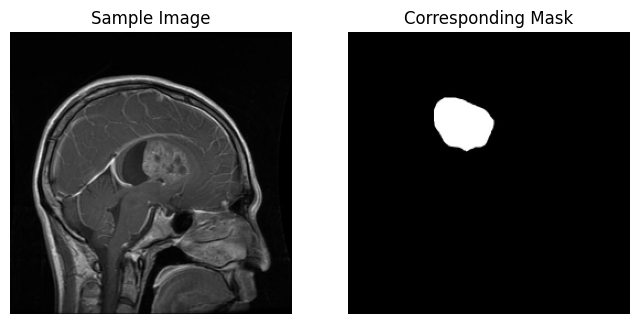

In [4]:
# STEP 4: Pick ONE sample image (for segmentation demo)

sample_class = '1'

img_folder = os.path.join(DATASET_PATH_SEG, "image", sample_class)
mask_folder = os.path.join(DATASET_PATH_SEG, "mask", sample_class)

img_path = os.path.join(img_folder, os.listdir(img_folder)[0])
mask_path = os.path.join(mask_folder, os.listdir(mask_folder)[0])

img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

img = cv2.resize(img, (256, 256))
mask = cv2.resize(mask, (256, 256))

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.title('Sample Image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(mask, cmap='gray')
plt.title('Corresponding Mask')
plt.axis('off')

plt.show()


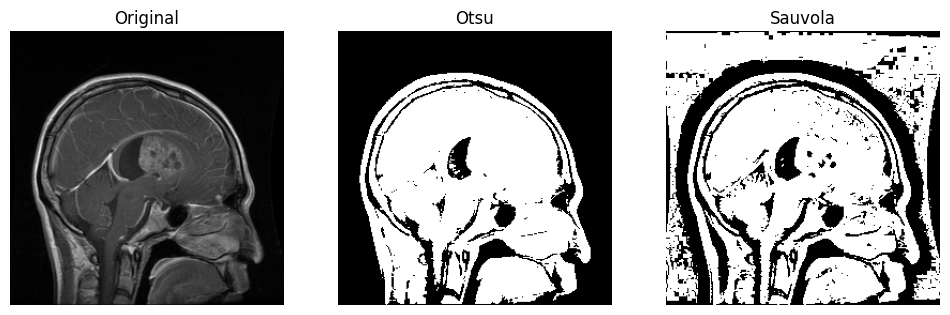

In [5]:
# STEP 5: Apply Otsu Thresholding

# Otsu (Global threshold)
_, otsu_mask = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)


# STEP 6: Apply Sauvola Thresholding (Adaptive)

# Convert image to float (required for Sauvola)
img_float = img.astype('float32') / 255.0

# Sauvola threshold
window_size = 25
sauvola_thresh = threshold_sauvola(img_float, window_size=window_size)

sauvola_mask = (img_float > sauvola_thresh).astype('uint8') * 255


# STEP 7: Show comparison

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img, cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(otsu_mask, cmap='gray')
plt.title("Otsu")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(sauvola_mask, cmap='gray')
plt.title("Sauvola")
plt.axis('off')

plt.show()


In [6]:
# Convert GT mask to binary (tumor vs background)
# Everything > 0 is tumor
gt = (mask > 0).astype('uint8')

# Convert predictions to binary
otsu_pred = (otsu_mask > 0).astype('uint8')
sauvola_pred = (sauvola_mask > 0).astype('uint8')


def dice_score(y_true, y_pred):
    intersection = (y_true * y_pred).sum()
    return (2. * intersection) / (y_true.sum() + y_pred.sum() + 1e-8)


def jaccard_score(y_true, y_pred):
    intersection = (y_true * y_pred).sum()
    union = y_true.sum() + y_pred.sum() - intersection
    return intersection / (union + 1e-8)


dice_otsu = dice_score(gt, otsu_pred)
dice_sauvola = dice_score(gt, sauvola_pred)

iou_otsu = jaccard_score(gt, otsu_pred)
iou_sauvola = jaccard_score(gt, sauvola_pred)

print("Otsu  -> Dice:", dice_otsu, " | Jaccard:", iou_otsu)
print("Sauvola -> Dice:", dice_sauvola, " | Jaccard:", iou_sauvola)


Otsu  -> Dice: 0.13300968034389116  | Jaccard: 0.07124283342207736
Sauvola -> Dice: 0.09646993103149852  | Jaccard: 0.050679488915966714


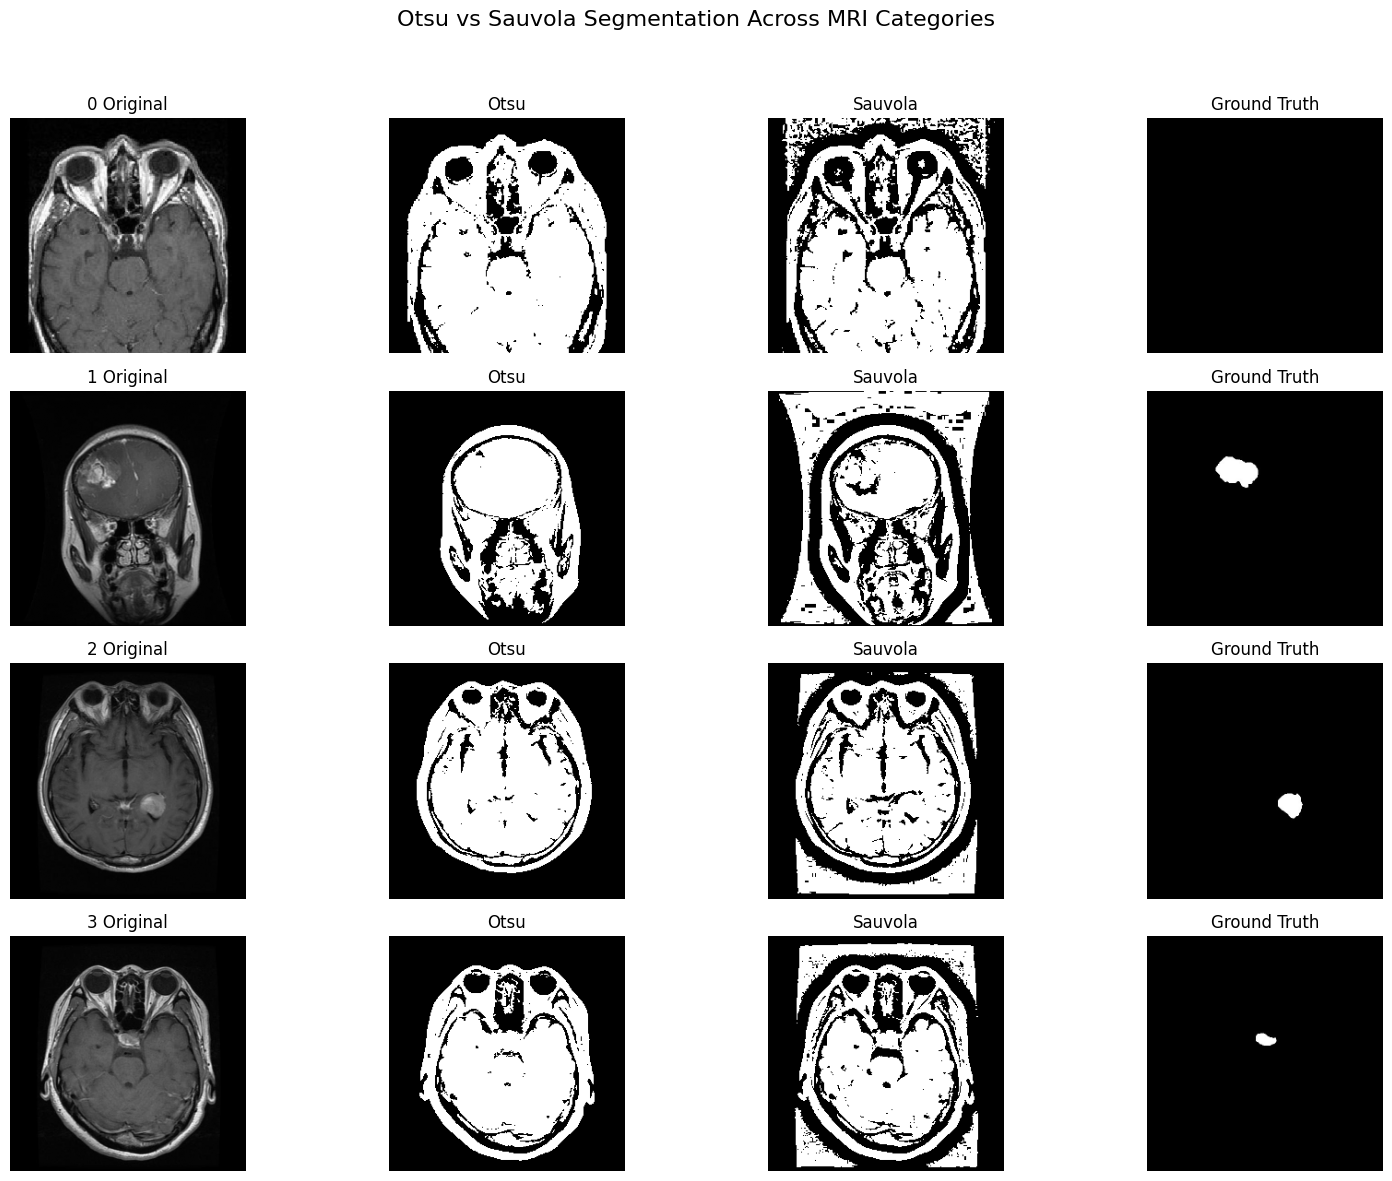

In [7]:
categories = ["0", "1", "2", "3"]

IMG_PATH = os.path.join(DATASET_PATH_SEG, "image")
MASK_PATH = os.path.join(DATASET_PATH_SEG, "mask")

plt.figure(figsize=(16, 12))

for i, cat in enumerate(categories):

    img_folder = os.path.join(IMG_PATH, cat)
    mask_folder = os.path.join(MASK_PATH, cat)

    img_files = sorted(os.listdir(img_folder))
    mask_files = sorted(os.listdir(mask_folder))

    # take minimum length to avoid mismatch crash
    min_len = min(len(img_files), len(mask_files))

    img_path = os.path.join(img_folder, img_files[0])
    mask_path = os.path.join(mask_folder, mask_files[0])

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    img = cv2.resize(img, (256, 256))
    mask = cv2.resize(mask, (256, 256))

    otsu_mask = (img > threshold_otsu(img)).astype(np.uint8)
    sauvola_mask = (img > threshold_sauvola(img, 25, 0.2)).astype(np.uint8)

    plt.subplot(4, 4, i*4 + 1)
    plt.imshow(img, cmap="gray")
    plt.title(f"{cat} Original")
    plt.axis("off")

    plt.subplot(4, 4, i*4 + 2)
    plt.imshow(otsu_mask, cmap="gray")
    plt.title("Otsu")
    plt.axis("off")

    plt.subplot(4, 4, i*4 + 3)
    plt.imshow(sauvola_mask, cmap="gray")
    plt.title("Sauvola")
    plt.axis("off")

    plt.subplot(4, 4, i*4 + 4)
    plt.imshow(mask, cmap="gray")
    plt.title("Ground Truth")
    plt.axis("off")

plt.suptitle("Otsu vs Sauvola Segmentation Across MRI Categories", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()
